# Libraries used:

numpy 1.19.5
<br>
tensorflow 2.4.1
<br>
pandas 1.2.4
<br>
matplotlib 3.3.4
<br>
tensorflow_addons 0.12.1 

In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [2]:
tf.random.set_seed(1234)

# Data processing and augmentation

In [3]:
df=pd.read_csv('Train.csv')
df.head(5)

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [4]:
fnames=[]
classes=[]
bbox=[]
for i in range(len(df)):
    fnames.append('Train_Images\\{}.jpg'.format(df['Image_ID'][i]))
    
    label_name=df['class'][i]
    if label_name=='fruit_healthy':
        labels=np.array([1,0,0])
    if label_name=='fruit_woodiness':
        labels=np.array([0,1,0])
    if label_name=='fruit_brownspot':
        labels=np.array([0,0,1])
    classes.append(labels)    
    
    bbox_coordinates=np.array([df['xmin'][i]+0.5*df['width'][i],df['ymin'][i]+0.5*df['height'][i],
                               df['width'][i],df['height'][i]])
    bbox.append(bbox_coordinates.astype('float32'))
    

In [5]:
fname_p=fnames[0]
fnames_sorted=[]
fnames_count=[]
count=0
for i in range(1,len(fnames)):
    count=count+1
    fname_i=fnames[i]
    if fname_i!=fname_p:
        fnames_sorted.append(fname_p)
        fname_p=fname_i
        fnames_count.append(count)
        count=0

fnames_appearing_once=np.array(fnames_sorted)[np.where(np.array(fnames_count)==1)[0]]
fnames_appearing_once_indexes=[]
for i in range(len(fnames_appearing_once)):
    fnames_appearing_once_indexes.append(fnames.index(fnames_appearing_once[i]))
    
    
bboxes_once=[]
classes_once=[]
for index in np.array(fnames_appearing_once_indexes,dtype='int'):
    bboxes_once.append(bbox[index])
    classes_once.append(classes[index])

In [6]:
ds_size=len(fnames_appearing_once)

fnames_dataset = tf.data.Dataset.from_tensor_slices(fnames_appearing_once)
classes_dataset = tf.data.Dataset.from_tensor_slices(classes_once)
bbox_dataset = tf.data.Dataset.from_tensor_slices(bboxes_once)

ds = tf.data.Dataset.zip((fnames_dataset, classes_dataset, bbox_dataset))

In [7]:
train_ratio = 0.80
ds_train1=ds.take(int(ds_size*train_ratio))
ds_test1=ds.skip(int(ds_size*train_ratio))

Augmentation: rotate images and bounding boxes by 90, 180 and 270 degrees

In [8]:
def bbox_rotation(bbox,deg):
    bbox=bbox.numpy()
    #deg 1: 90, 2:180, 3: 270
    if deg==0:
        return tf.constant(bbox)
    if deg==3:
        return tf.constant([512-bbox[1],bbox[0],bbox[3],bbox[2]],dtype='float32')
    
    elif deg==2:
        return tf.constant([512-bbox[0],512-bbox[1],bbox[2],bbox[3]], dtype='float32')

    elif deg==1:
        return tf.constant([bbox[1],512-bbox[0],bbox[3],bbox[2]], dtype='float32')
    else:
        return NotImplemented



IMG_SIZE=512
def process_img(img, deg):
    image = tf.io.read_file(img)
    image = tf.image.decode_jpeg(image, channels=3) 
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image=tfa.image.rotate(image,tf.constant(np.pi*0.5*deg))
    return image

def read_images(fnames, classes, bbox, deg):
    img = process_img(fnames, deg)
    bbox=bbox_rotation(bbox,deg)
    return img, classes, bbox

In [9]:
ds_train=ds_train1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 0.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_train_rotate1=ds_train1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 1.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_train_rotate2=ds_train1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 2.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_train_rotate3=ds_train1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 3.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)


ds_train=ds_train.concatenate(ds_train_rotate1)
ds_train=ds_train.concatenate(ds_train_rotate2)
ds_train=ds_train.concatenate(ds_train_rotate3)

ds_test=ds_test1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 0.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_test_rotate1=ds_test1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 1.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_test_rotate2=ds_test1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 2.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_test_rotate3=ds_test1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 3.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_test=ds_test.concatenate(ds_test_rotate1)
ds_test=ds_test.concatenate(ds_test_rotate2)
ds_test=ds_test.concatenate(ds_test_rotate3)

In [10]:
ds_train_final = ds_train.map(lambda a, b, c: (a, (b,c)))
ds_test_final = ds_test.map(lambda a, b, c: (a, (b,c)))

# Model building

In [11]:
@tf.function
def map_fn(fn, arrays, dtype=tf.float32):
    indices = tf.range(tf.shape(arrays[0])[0])
    out = tf.map_fn(lambda ii: fn(*[array[ii] for array in arrays]), indices, 
                    fn_output_signature=dtype)
    return out

@tf.function
def calc_reg_targets_single_prop(bbox,bbox_prop):
    
    t_x_star=(bbox[:,0]-bbox_prop[:,0])/bbox_prop[:,2]
    t_y_star=(bbox[:,1]-bbox_prop[:,1])/bbox_prop[:,3]
    t_w_star=tf.math.log(bbox[:,2]/bbox_prop[:,2])
    t_h_star=tf.math.log(bbox[:,3]/bbox_prop[:,3])

    target=tf.stack([t_x_star,t_y_star,t_w_star,t_h_star],axis=-1)

    return target

@tf.function
def IoU(inputs):
    anchor=inputs[:,:4]
    target=inputs[:,4:]
    
    gl = tfa.losses.GIoULoss(mode = 'iou') 
    
    boxes1 = tf.stack([anchor[:,1]-0.5*anchor[:,3], anchor[:,0]-0.5*anchor[:,2], 
                          anchor[:,1]+0.5*anchor[:,3], anchor[:,0]+0.5*anchor[:,2]],axis=-1)
    boxes2 = tf.stack([target[:,1]-0.5*target[:,3], target[:,0]-0.5*target[:,2], 
                          target[:,1]+0.5*target[:,3], target[:,0]+0.5*target[:,2]],axis=-1)
    loss = map_fn(gl, (boxes1, boxes2))
    return 1-loss

#@tf.function
def bounding_box_crop(bbox):
    #bbox input: [xc,yc,w,h]
    if tf.shape(tf.shape(bbox))==2:
        #bbox_x_y: [xmin,ymin,xmax,ymax]
        bbox_x_y=tf.stack([bbox[:,0]-0.5*bbox[:,2],bbox[:,1]-0.5*bbox[:,3],
                             bbox[:,0]+0.5*bbox[:,2],bbox[:,1]+0.5*bbox[:,3]],axis=-1)
        bbox_x_y=tf.where(tf.less(bbox_x_y,0.),0.,bbox_x_y)
        bbox_x_y=tf.where(tf.greater(bbox_x_y,512.),512.,bbox_x_y)
        
        bbox_new=tf.stack([(bbox_x_y[:,0]+bbox_x_y[:,2])/2,(bbox_x_y[:,1]+bbox_x_y[:,3])/2,
                             (bbox_x_y[:,2]-bbox_x_y[:,0]),(bbox_x_y[:,3]-bbox_x_y[:,1])],axis=-1)
        return bbox_new
    
    elif tf.shape(tf.shape(bbox))==1:  
        bbox_x_y=tf.stack([bbox[0]-0.5*bbox[2],bbox[1]-0.5*bbox[3],
                             bbox[0]+0.5*bbox[2],bbox[1]+0.5*bbox[3]],axis=-1)
        bbox_x_y=tf.where(tf.less(bbox_x_y,0.),0.,bbox_x_y)
        bbox_x_y=tf.where(tf.greater(bbox_x_y,512.),512.,bbox_x_y)
        bbox_new=tf.stack([(bbox_x_y[0]+bbox_x_y[2])/2,(bbox_x_y[1]+bbox_x_y[3])/2,
                             (bbox_x_y[2]-bbox_x_y[0]),(bbox_x_y[3]-bbox_x_y[1])],axis=-1)
        return bbox_new

@tf.function
def distorted_bbox(bbox,scale=1):
    nr_boxes=tf.shape(bbox)[0]
    
    random_val=tf.random.uniform([nr_boxes,4], minval=-1, maxval=1)
    
    x_offset=0.16*random_val[:,0]*scale 
    y_offset=0.16*random_val[:,1]*scale 

    w_scale=(1.3)**(random_val[:,2]*scale)
    h_scale=(1.3)**(random_val[:,3]*scale)
    
    dist_bbox=tf.stack([bbox[:,0]+x_offset*bbox[:,2],bbox[:,1]+y_offset*bbox[:,2],
                        bbox[:,2]*w_scale,bbox[:,3]*h_scale],axis=-1)
    
    dist_bbox_x_y=tf.stack([dist_bbox[:,0]-0.5*dist_bbox[:,2],dist_bbox[:,1]-0.5*dist_bbox[:,3],
                             dist_bbox[:,0]+0.5*dist_bbox[:,2],dist_bbox[:,1]+0.5*dist_bbox[:,3]],axis=-1)
    
    
    dist_bbox_final=bounding_box_crop(dist_bbox)

    IoU1=IoU(tf.concat([dist_bbox_final,bbox],axis=-1)) 
    
    return dist_bbox_final, IoU1
    

@tf.function
def smooth_L1(x):
    ans=tf.where(tf.abs(x)<1,0.5*x**2,tf.abs(x)-0.5)
    return tf.reduce_sum(ans)
        
@tf.function
def CN_training_loss(iou_pred, class_pred, target_pred, IoU_t, class_t, target_t):
    
    cce = tf.keras.losses.CategoricalCrossentropy()
    class_loss=cce(class_t, class_pred)
    
    mse = tf.keras.losses.MeanSquaredError()
    iou_mse=mse(IoU_t, iou_pred)
    
    reg_loss=smooth_L1(target_pred-target_t)
    
    return iou_mse+reg_loss+class_loss
    

### Bounding box warping investigation: used to determine parameters used in bounding box distortion for classifier training

In [12]:
# x_offset=0.16
# y_offset=0.16

# w_scale=1.3
# h_scale=1.3

# w=10.
# h=5.

# random_val=1

# scale=2
    
# x_offset=0.16*random_val*scale #0.16 2std
# y_offset=0.16*random_val*scale 

# w_scale=(1.3)**(random_val*scale)# 1/1.3 - 1.3
# h_scale=(1.3)**(random_val*scale)
    
# a=tf.constant([[3.+w*x_offset,4.+h*y_offset,w*w_scale,h*h_scale]])
# b=tf.constant([[3.,4.,w,h]])

# inputs=tf.concat([a,b],axis=-1)

# print('IoU between given bbox and warped bbox:',IoU(inputs))


## Classifier network

In [13]:
base_model = tf.keras.applications.VGG16(
                weights='imagenet', 
                input_shape=(64, 64, 3), 
                include_top=False)

conv1=tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding='same')(base_model.layers[-6].output)

flatten1=tf.keras.layers.Flatten()(conv1)
bn1=tf.keras.layers.BatchNormalization()(flatten1)
dense1=tf.keras.layers.Dense(1024, activation='relu')(bn1)
bn2=tf.keras.layers.BatchNormalization()(dense1)
dense2=tf.keras.layers.Dense(512, activation='relu')(bn2)
       
box_reg=tf.keras.layers.Dense(4, activation=None)(dense2)
iou_layer=tf.keras.layers.Dense(1, activation='sigmoid')(dense2)

box_cls=tf.keras.layers.Dense(3, activation='softmax')(dense2)
             
concat1=tf.keras.layers.Concatenate(axis=-1)([iou_layer,box_cls,box_reg])

cn_model=tf.keras.models.Model(inputs=base_model.inputs, outputs=concat1)
        

In [14]:
class CN(tf.keras.models.Model):
    def __init__(self):
        super(CN, self).__init__()
                 

        self.base_model = cn_model 
        for i in range(14):
            self.base_model.layers[i].trainable=False
        
        self.distortion_scale=1

    def call(self, image):
        image=tf.reverse(image, axis=[-1])
        image=tf.image.per_image_standardization(image)
        
        x = self.base_model(image, training=False)
        
        return x
    
    
    @tf.function
    def bbox_prediction(self, img, bbox_dist): #only one img, bbox
        bbox_dist=tf.expand_dims(bbox_dist,axis=0)
        img=tf.expand_dims(img,axis=0)
        bbox_dist_cropped_coordinates=tf.stack([bbox_dist[:,1]-0.5*bbox_dist[:,3], 
                                                bbox_dist[:,0]-0.5*bbox_dist[:,2], 
                          bbox_dist[:,1]+0.5*bbox_dist[:,3], bbox_dist[:,0]+0.5*bbox_dist[:,2]],
                                               axis=-1)/512
        
        img_cropped=tf.image.crop_and_resize(
            img, bbox_dist_cropped_coordinates,
            box_indices=tf.range(0, tf.shape(bbox_dist)[0], 1), crop_size=[64,64]) 
        
        y_pred = self(img_cropped)
        iou_pred1, class_pred1, target_pred1 = tf.split(y_pred, [1, 3, 4], -1)
        
        t_x=target_pred1[:,0]
        t_y=target_pred1[:,1]
        t_w=target_pred1[:,2]
        t_h=target_pred1[:,3]
        
        x=t_x*bbox_dist[:,2]+bbox_dist[:,0]
        y=t_y*bbox_dist[:,3]+bbox_dist[:,1]
        w=tf.math.exp(t_w)*bbox_dist[:,2]
        h=tf.math.exp(t_h)*bbox_dist[:,3]
        
        bbox_pred=tf.stack([x,y,w,h], axis=-1)
        
        return tf.squeeze(iou_pred1,axis=0), tf.squeeze(class_pred1,axis=0), tf.squeeze(bbox_pred,axis=0)
        

    
    #@tf.function
    def train_step(self, data):
        
        inputs= data[0]
        targets= data[1]
        
        classes=targets[0]
        bbox=targets[1]
        
        #sample distorted bbox, calculate IoU between real bbox and distorted bbox
        bbox_dist, IoU_dist_bbox=distorted_bbox(bbox,scale=self.distortion_scale)
        
        bbox_dist_cropped_coordinates=tf.stack([bbox_dist[:,1]-0.5*bbox_dist[:,3], 
                                                bbox_dist[:,0]-0.5*bbox_dist[:,2], 
                          bbox_dist[:,1]+0.5*bbox_dist[:,3], bbox_dist[:,0]
                                                +0.5*bbox_dist[:,2]],axis=-1)/512
        
        img_cropped=tf.image.crop_and_resize(
            inputs, bbox_dist_cropped_coordinates, 
            box_indices=tf.range(0, tf.shape(bbox_dist)[0], 1), crop_size=[64,64])
        
        reg_target=calc_reg_targets_single_prop(bbox,bbox_dist)
        
        
        with tf.GradientTape() as tape:
            y_pred = self(img_cropped)
            iou_pred1, class_pred1, target_pred1 = tf.split(y_pred, [1, 3, 4], -1)
            
            loss_value = CN_training_loss(iou_pred1, class_pred1, target_pred1,
                                           IoU_dist_bbox, classes, reg_target)
        
        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(classes, class_pred1)
       
        return {m.name: m.result() for m in self.metrics}#{'loss_value': loss_value} 
    
    
    def test_step(self, data):
        inputs= data[0]
        targets= data[1]
        
        classes=targets[0]
        bbox=targets[1]
        
        bbox_dist, IoU_dist_bbox=distorted_bbox(bbox,scale=self.distortion_scale)
        
        bbox_dist_cropped_coordinates=tf.stack([bbox_dist[:,1]-0.5*bbox_dist[:,3], 
                                                bbox_dist[:,0]-0.5*bbox_dist[:,2], 
                          bbox_dist[:,1]+0.5*bbox_dist[:,3], bbox_dist[:,0]
                                                +0.5*bbox_dist[:,2]],axis=-1)/512
        
        img_cropped=tf.image.crop_and_resize(
            inputs, bbox_dist_cropped_coordinates, 
            box_indices=tf.range(0, tf.shape(bbox_dist)[0], 1), crop_size=[64,64])
        
        
        y_pred = self(img_cropped)
        iou_pred1, class_pred1, target_pred1 = tf.split(y_pred, [1, 3, 4], -1)
        
        self.compiled_metrics.update_state(classes, class_pred1)
        
        return {m.name: m.result() for m in self.metrics}
        

In [15]:
cn1=CN()
inputs = tf.keras.Input(shape=(64, 64, 3))
cn1(inputs)

cn1.base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

# Training:
To train the classifier, uncomment the following block. This will reproduce and save the weight files in the 'checkpoints' folder. If the cell is not run, the weights will be loaded from the 'checkpoints' folder.

In [16]:
# cn1=CN()
# cn1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=None,
#            metrics=[tf.keras.metrics.CategoricalAccuracy()])

# ds_batched = ds_train_final.batch(10, drop_remainder=True)
# ds_batched_test = ds_test_final.batch(10, drop_remainder=True)

# cn1.distortion_scale=0.5
# cn1.fit(x=ds_batched,  shuffle=True, epochs=10, 
#     validation_data=ds_batched_test, validation_steps=50)

# cn1.distortion_scale=1
# cn1.fit(x=ds_batched,  shuffle=True, epochs=10, 
#     validation_data=ds_batched_test, validation_steps=50)

# cn1.distortion_scale=1.25
# cn1.fit(x=ds_batched,  shuffle=True, epochs=5, 
#     validation_data=ds_batched_test, validation_steps=50)

# cn1.distortion_scale=1.5
# cn1.fit(x=ds_batched,  shuffle=True, epochs=5, 
#     validation_data=ds_batched_test, validation_steps=50)

# cn1.distortion_scale=1.75
# cn1.fit(x=ds_batched,  shuffle=True, epochs=5, 
#     validation_data=ds_batched_test, validation_steps=50)

# cn1.distortion_scale=2
# cn1.fit(x=ds_batched,  shuffle=True, epochs=5, 
#     validation_data=ds_batched_test, validation_steps=50)


# cn1.save_weights('./checkpoints/CN_9600_mini_batches_adam_0.0001_DS2_40epochs_no_background')

In [17]:
cn1=CN()
cn1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=None,
           metrics=[tf.keras.metrics.CategoricalAccuracy()])

cn1.load_weights('./checkpoints/CN_9600_mini_batches_adam_0.0001_DS2_40epochs_no_background') 


# Visualization of classifier regressor 

In [18]:
from matplotlib import cm
def visualize_classifier(image,bbox):  
    bbox_list=[bbox]
    iou_pred1, class_pred1, bbox_updated1= cn1.bbox_prediction(image, bbox)
    bbox_updated1=bounding_box_crop(bbox_updated1)
    bbox_list.append(bbox_updated1)
    
    for k in range(4):
        iou_pred1, class_pred1, bbox_updated1= cn1.bbox_prediction(image, bbox_updated1)
        bbox_updated1=bounding_box_crop(bbox_updated1)
        
        bbox_list.append(bbox_updated1)
        
    plt.figure()
    plt.imshow(np.squeeze(image.numpy()))

    for i in range(0, len(bbox_list)):
        bbox_x=[bbox_list[i][0]-0.5*bbox_list[i][2],
                bbox_list[i][0]+0.5*bbox_list[i][2],
                bbox_list[i][0]+0.5*bbox_list[i][2],
                bbox_list[i][0]-0.5*bbox_list[i][2],
               bbox_list[i][0]-0.5*bbox_list[i][2]]
        bbox_y=[bbox_list[i][1]-0.5*bbox_list[i][3],
                bbox_list[i][1]-0.5*bbox_list[i][3],
                bbox_list[i][1]+0.5*bbox_list[i][3],
                bbox_list[i][1]+0.5*bbox_list[i][3],
               bbox_list[i][1]-0.5*bbox_list[i][3]]
        
        cmap='plasma'
        rgb = cm.get_cmap(cmap)(i/(len(bbox_list)-1))#[np.newaxis, :, :3]
        print(rgb)
        plt.plot(bbox_x,bbox_y,color=rgb,linewidth=3,label='Step {}'.format(i))
    plt.legend(bbox_to_anchor=(1.37,1),loc='upper right')  


(0.050383, 0.029803, 0.527975, 1.0)
(0.417642, 0.000564, 0.65839, 1.0)
(0.69284, 0.165141, 0.564522, 1.0)
(0.881443, 0.392529, 0.383229, 1.0)
(0.98826, 0.652325, 0.211364, 1.0)
(0.940015, 0.975158, 0.131326, 1.0)
(0.050383, 0.029803, 0.527975, 1.0)
(0.417642, 0.000564, 0.65839, 1.0)
(0.69284, 0.165141, 0.564522, 1.0)
(0.881443, 0.392529, 0.383229, 1.0)
(0.98826, 0.652325, 0.211364, 1.0)
(0.940015, 0.975158, 0.131326, 1.0)


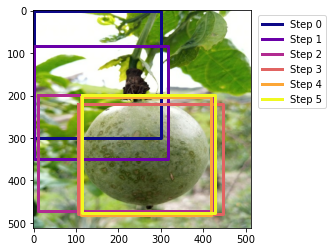

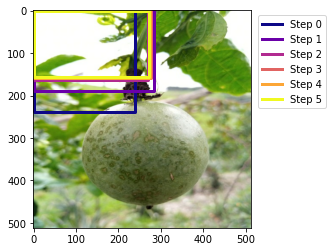

In [19]:
test_data=ds_test_final.take(1)
for image, target in test_data:
    #bbox=tf.constant([171.,171.,341.,341.])
    bbox=tf.constant([150.,150.,300.,300.])
    visualize_classifier(image,bbox)
    
    bbox=tf.constant([120.,120.,240.,240.])
    visualize_classifier(image,bbox)